In [2]:
import numpy as np
import sympy as sym
from quantiphy import Quantity


def print_float(var_name: str, value: float, unit: str = ''):
    print(var_name, ": ", Quantity(value, unit))



### Calculating parasitic capacitance and inductance and calculating the optimal RC snubber
ref EDN: [https://www.edn.com/optimizing-snubber-design-through-frequency-domain-analysis/](https://www.edn.com/optimizing-snubber-design-through-frequency-domain-analysis/)

ref TI: [https://e2e.ti.com/blogs_/b/powerhouse/posts/calculate-an-r-c-snubber-in-seven-steps](https://e2e.ti.com/blogs_/b/powerhouse/posts/calculate-an-r-c-snubber-in-seven-steps)



In [3]:

def calculate_parasitics_edn(f1, f2, v1, v2, vin, cadd):
    f = np.array([f1, f2])

    w = f * 2*np.pi 
    tr1 = 1/f1  # period
    
    a = -np.log((v2 - vin)/(v1 - vin))/tr1

    #overshoot without snubber
    overshoot = (v1 - vin)/vin
    print(v1)
    print(vin)

    l1 = (1/cadd) * ((1/((w[1]**2)+a**2))-(1/((w[0]**2)+a**2)))
    c1 = 1/(((w[0]**2)+(a**2))*l1)
    r1 = 2*a*l1
    

    return l1, c1, r1, overshoot


def calculate_parasitics_ti(f1, f2, v1, v2, vin, cadd):
    m = f1/f2
    c1 = cadd/((m**2)-1)
    l1 = ((m**2)-1)/(((2*np.pi*f1)**2)*(cadd))
    r1 = 0

    return l1, c1, r1


def calculate_optimized_res_edn(c1, l1, r1, gsnb, c_snb):
    return np.sqrt((l1*(2*c1 + c_snb)*(c1 + c_snb))/(2*(c_snb**2)*c1))

def calculate_optimized_snubber_edn(c1, l1, r1, gsnb):

    c_snb = c1 * ((4-(4*gsnb))/(2*gsnb-1))
    
    rsnb_opt = calculate_optimized_res_edn(c1, l1, r1, gsnb, c_snb)
    
    return c_snb, rsnb_opt


def calculate_optimized_res_ti(c1, l1, r1, gsnb, c_snb):
    return np.sqrt(l1/c1)

def calculate_optimized_snubber_ti(c1, l1, r1, gsnb):

    c_snb = c1 * 3

    rsnb_opt = calculate_optimized_res_ti(c1, l1, r1, gsnb, c_snb)

    return c_snb, rsnb_opt

def calculate_max_power_dissipation(csnb, vin_max, fsw):
    return csnb * fsw * (vin_max**2)


### Example of edn

In [4]:
#EXAMPLE
vin = Quantity(12, "V")
print(vin)
# without capacitor
f1 = Quantity(106e6, "Hz")
v1 = Quantity(23.85, "V")
v2 = Quantity(23.55, "V")

# with capacitor
cadd = Quantity(6e-9, "F")
f2 = Quantity(47.4e6, "Hz")

l1 , c1, r1, overshoot = calculate_parasitics_edn(f1, f2, v1, v2, vin, cadd)
print("EXAMPLE: ")
print_float("L1", l1, "H")
print_float("C1", c1, "F")
print_float("R1", r1, "R")

l1 = 1.5e-9
c1 = 0.5e-9
r1 = 10e-3

csnb , rsnb = calculate_optimized_snubber_edn(c1 , l1, r1, 0.7)
print_float("csnb", csnb, "F")
print_float("rsnb", rsnb, "R")



12 V
23.85 V
12 V
EXAMPLE: 
L1 :  1.5031 nH
C1 :  1.4998 nF
R1 :  8.1714 mR
csnb :  1.5 nF
rsnb :  1.8257 R


### HIGH SIDE

In [5]:
#high side
vin_max = Quantity(50, "V")
fsw = Quantity(12e3, "Hz")
vin = Quantity(5, "V")

#Expected overshoot
overshoot = 0.4

# without capacitor
f1 = Quantity(16.67e6, "Hz")
v1 = Quantity(8.462, "V")
v2 = Quantity(5.962, "V")

# with capacitor
cadd = Quantity(10e-9, "F")
f2 = Quantity(14.15e6, "Hz")

print("method EDN:")
l1, c1, r1, default_overshoot = calculate_parasitics_edn(f1, f2, v1, v2, vin, cadd)
print("high_side: ")
print_float("L1", l1, "H")
print_float("C1", c1, "F")
print_float("R1", r1, "R")
print_float("default overhoot", default_overshoot)
csnb, rsnb = calculate_optimized_snubber_edn(c1, l1, r1, overshoot/default_overshoot)
print_float("csnb", csnb, "F")
print_float("rsnb", rsnb, "R")

p_loss = calculate_max_power_dissipation(csnb, vin_max, fsw)
print_float("P_loss", p_loss, "W")

print("method TI:")
l1, c1, r1 = calculate_parasitics_ti(f1, f2, v1, v2, vin, cadd)
print("high_side: ")
print_float("L1", l1, "H")
print_float("C1", c1, "F")
print_float("R1", r1, "R")

csnb, rsnb = calculate_optimized_snubber_ti(c1, l1, r1, 0.7)
print_float("csnb", csnb, "F")
print_float("rsnb", rsnb, "R")

p_loss = calculate_max_power_dissipation(csnb, vin_max, fsw)
print_float("P_loss", p_loss, "W")

#optimizing snubber
c_snb = np.arange(10e-9, 300e-9, 100e-9)

for c in c_snb:
    print_float("csnb:", c, "F")
    print_float("rsnb: ", calculate_optimized_res_edn(c1, l1, r1, 0.7, c), "R")
    print_float("p_loss: ", calculate_max_power_dissipation(
        csnb, vin_max, fsw), "W")


method EDN:
8.462 V
5 V
high_side: 
L1 :  3.2097 nH
C1 :  27.266 nF
R1 :  137.04 mR
default overhoot :  692.4m
csnb :  296.38 nF
rsnb :  275.86 mR
P_loss :  8.8914 W
method TI:
high_side: 
L1 :  3.5358 nH
C1 :  25.78 nF
R1 :  0 R
csnb :  77.339 nF
rsnb :  370.34 mR
P_loss :  2.3202 W
csnb: :  10 nF
rsnb:  :  1.229 R
p_loss:  :  2.3202 W
csnb: :  110 nF
rsnb:  :  352.6 mR
p_loss:  :  2.3202 W
csnb: :  210 nF
rsnb:  :  309.68 mR
p_loss:  :  2.3202 W


### LOW SIDE

In [6]:
#LOW SIDE
vin = Quantity(5, "V")

# without capacitor
f1 = Quantity(1/76e-9, "Hz")
v1 = Quantity(7.347, "V")
v2 = Quantity(5.418, "V")

overshoot = 0.2
# with capacitor
cadd = Quantity(335e-9, "F")
f2 = Quantity(1/69.33e-9, "Hz")

print("method EDN:")
l1, c1, r1, overshoot = calculate_parasitics_edn(f1, f2, v1, v2, vin, cadd)
print("#LOW SIDE: ")
print_float("L1", l1, "H")
print_float("C1", c1, "F")
print_float("R1", r1, "R")

csnb, rsnb = calculate_optimized_snubber_edn(
    c1, l1, r1, 0.7)
print_float("csnb", csnb, "F")
print_float("rsnb", rsnb, "R")

p_loss = calculate_max_power_dissipation(csnb, vin_max, fsw)
print_float("P_loss", p_loss, "W")

print("method TI:")
l1, c1, r1 = calculate_parasitics_ti(f1, f2, v1, v2, vin, cadd)
print("#LOW SIDE: ")
print_float("L1", l1, "H")
print_float("C1", c1, "F")
print_float("R1", r1, "R")

csnb, rsnb = calculate_optimized_snubber_ti(c1, l1, r1, 0.6)
print_float("csnb", csnb, "F")
print_float("rsnb", rsnb, "R")
p_loss = calculate_max_power_dissipation(csnb, vin_max, fsw)
print_float("P_loss", p_loss, "W")

#optimizing snubber
c_snb = np.arange(10e-9, 400e-9, 100e-9)

for c in c_snb:
    print_float("csnb:", c, "F")
    print_float("rsnb: ", calculate_optimized_res_edn(c1, l1, r1, 0.7, c), "R")
    print_float("p_loss: ", calculate_max_power_dissipation(csnb, vin_max, fsw), "W")



method EDN:
7.347 V
5 V
#LOW SIDE: 
L1 :  -64.131 pH
C1 :  -2.1214 uF
R1 :  -2.9119 mR
csnb :  -6.3642 uF
rsnb :  5.7956 mR
P_loss :  -190.93 W
method TI:
#LOW SIDE: 
L1 :  -73.295 pH
C1 :  -1.9961 uF
R1 :  0 R
csnb :  -5.9884 uF
rsnb :  6.0596 mR
P_loss :  -179.65 W
csnb: :  10 nF
rsnb:  :  1.205 R
p_loss:  :  -179.65 W
csnb: :  110 nF
rsnb:  :  105.41 mR
p_loss:  :  -179.65 W
csnb: :  210 nF
rsnb:  :  53.033 mR
p_loss:  :  -179.65 W
csnb: :  310 nF
rsnb:  :  34.441 mR
p_loss:  :  -179.65 W


### Optimizing snubber

Calculating interesting values

and crating a dict of dict in the format of `dfs[mosfet][voltage]`

In [41]:
from cmath import nan
import csv
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
#Import test
file_name = "test.csv"
df = pd.read_csv(file_name)
df_split = {}
#split dataframe in the low mosfet
df_split["low"] = df[[column for column in df if not("high" in column)]]
#remove low in the columns name 
df_split["low"].columns = df_split["low"].columns.str.replace("_low", "")
#split dataframe in thehigh mosfet
df_split["high"] = df[[column for column in df if not("low" in column)]]
#remove high in the columns name
df_split["high"].columns = df_split["high"].columns.str.replace("_high", "")


#Calculate parameters with the test
for mosfet in df_split:
    df_split[mosfet]["Z (F/R)"] = df_split[mosfet]["C (n)"] / df_split[mosfet]["R (R)"]
    df_split[mosfet]["Overshoot"] = (df_split[mosfet]["Vmax (V)"] - df_split[mosfet]["Vin (V)"]) / df_split[mosfet]["Vin (V)"]
    df_split[mosfet]["P_loss"] = df_split[mosfet]["R (R)"] * \
        (df_split[mosfet]["Vrms_res (V)"] **2)
    df_split[mosfet]["V_max_60V"] = (60 * \
                                     df_split[mosfet]["Overshoot"]) + 60

dfs = {}

#split dataframe in dicts separated by voltage
for mosfet in df_split:
    if (not (mosfet in dfs.keys())):
        dfs[mosfet] = {}
    for voltage in df_split[mosfet]["Vin (V)"]:
        if (not(round(voltage) in dfs[mosfet].keys())):
            dfs[mosfet][round(voltage/5)*5] = df_split[mosfet][round(
                df["Vin (V)"]/5)*5 == round(voltage/5)*5]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


for mosfet in dfs:
    for voltage in dfs[mosfet]:
        print("Mosfet: ", mosfet, " With voltage: ", voltage)
        display(dfs[mosfet][voltage])
    


Mosfet:  low  With voltage:  20


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
0,1,10,ceramic,1.0,no,34.98,20.50,0.262,NaN,750.0,https://drive.google.com/file/d/1urDoZmM_0dxF4...,10.0,0.706341,0.068644,102.380488
1,2,50,ceramic,0.5,yes,31.22,20.50,0.325,NaN,750.0,https://drive.google.com/file/d/18HUSABfrElJoY...,100.0,0.522927,0.052813,91.375610
3,4,50,ceramic,0.5,yes,30.75,20.00,0.121,27.0,750.0,https://drive.google.com/file/d/1ywRKfR01ea8x7...,100.0,0.537500,0.007320,92.250000
4,5,100,ceramic,1.0,yes,29.27,20.14,NaN,24.0,750.0,https://drive.google.com/file/d/1GIFfc-5cQqIg_...,100.0,0.453327,NaN,87.199603
5,6,100,ceramic,0.5,yes,30.06,20.04,0.128,24.0,750.0,https://drive.google.com/file/d/1c893HUB3y1k5d...,200.0,0.500000,0.008192,90.000000
6,7,200,ceramic,1.0,yes,27.16,20.03,0.688,29.0,750.0,NaN,200.0,0.355966,0.473344,81.357963
7,8,300,ceramic,1.0,yes,27.16,20.12,1.010,29.0,750.0,NaN,300.0,0.349901,1.020100,80.994036
8,9,300,ceramic,1.0,yes,28.00,20.29,NaN,NaN,13750.0,https://drive.google.com/file/d/1aqqRjw1J6HGUy...,300.0,0.379990,NaN,82.799409
9,10,400,ceramic,1.0,yes,27.37,20.16,NaN,33.0,750.0,https://drive.google.com/file/d/1ulcm2qe-afIE0...,400.0,0.357639,NaN,81.458333
10,11,300,ceramic,1.0,yes,28.00,20.26,NaN,28.0,750.0,https://drive.google.com/file/d/1BRDJ9_LVUk6pT...,300.0,0.382034,NaN,82.922014


Mosfet:  low  With voltage:  50


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
2,3,50,ceramic,0.5,yes,92.24,50.28,0.489,28.0,750.0,https://drive.google.com/file/d/1EWkjw-mEnDr3z...,100.0,0.834527,0.119561,110.071599
12,13,300,ceramic,1.0,yes,91.45,49.35,2.560,52.0,750.0,https://drive.google.com/file/d/1Yo_8GvGC-vBK4...,300.0,0.853090,6.553600,111.185410
20,21,300,ceramic,1.0,yes,92.08,49.22,NaN,NaN,NaN,https://drive.google.com/file/d/1_MpZ1sWD308y2...,300.0,0.870784,NaN,112.247054
30,31,200,polyester,1.0,yes,67.92,50.30,NaN,NaN,NaN,NaN,200.0,0.350298,NaN,81.017893


Mosfet:  low  With voltage:  10


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
13,14,300,ceramic,1.0,yes,13.96,10.35,NaN,NaN,NaN,NaN,300.0,0.348792,NaN,80.927536
22,23,200,polyester,1.0,yes,13.65,10.32,NaN,NaN,NaN,https://drive.google.com/file/d/1Ri2reZCAXUkRR...,200.0,0.322674,NaN,79.360465


Mosfet:  low  With voltage:  25


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
15,16,300,ceramic,1.0,yes,37.49,25.32,NaN,NaN,NaN,https://drive.google.com/file/d/1J0cYEB0ccUVAi...,300.0,0.480648,NaN,88.838863
25,26,200,polyester,1.0,yes,32.47,25.35,NaN,NaN,NaN,https://drive.google.com/file/d/1KA6bcSFJPbI89...,200.0,0.280868,NaN,76.852071


Mosfet:  low  With voltage:  30


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
16,17,300,ceramic,1.0,yes,45.65,30.00,NaN,NaN,NaN,https://drive.google.com/file/d/1x4fl38kCbuGYz...,300.0,0.521667,NaN,91.300000
26,27,200,polyester,1.0,yes,39.06,29.98,NaN,NaN,NaN,https://drive.google.com/file/d/1DRn_R1LQ13Iji...,200.0,0.302869,NaN,78.172115


Mosfet:  low  With voltage:  35


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
17,18,300,ceramic,1.0,yes,56.63,35.16,NaN,NaN,NaN,https://drive.google.com/file/d/12tXokcIKmDSKq...,300.0,0.610637,NaN,96.638225
27,28,200,polyester,1.0,yes,46.27,35.17,NaN,NaN,NaN,https://drive.google.com/file/d/1kPGX7QGOAgnb-...,200.0,0.315610,NaN,78.936594


Mosfet:  low  With voltage:  40


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
18,19,300,ceramic,1.0,yes,68.24,39.90,NaN,NaN,NaN,https://drive.google.com/file/d/1b_lCZ0-Pz2oYW...,300.0,0.710276,NaN,102.616541
28,29,200,polyester,1.0,yes,54.43,40.47,NaN,NaN,NaN,NaN,200.0,0.344947,NaN,80.696812


Mosfet:  low  With voltage:  45


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
19,20,300,ceramic,1.0,yes,81.10,45.08,NaN,NaN,NaN,https://drive.google.com/file/d/1_MpZ1sWD308y2...,300.0,0.799024,NaN,107.941437
29,30,200,polyester,1.0,yes,61.02,45.12,NaN,NaN,NaN,NaN,200.0,0.352394,NaN,81.143617


Mosfet:  low  With voltage:  15


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
23,24,200,polyester,1.0,yes,19.29,14.96,NaN,NaN,NaN,https://drive.google.com/file/d/1prjn_Zll8qf-3...,200.0,0.289439,NaN,77.36631


Mosfet:  low  With voltage:  5


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
31,32,0,NaN,inf,no,NaN,5.0,NaN,NaN,NaN,https://drive.google.com/file/d/1qHuv_K1wD7RB_...,0.0,NaN,NaN,NaN
32,33,200,polyester,0.0,no,NaN,5.0,NaN,NaN,NaN,NaN,inf,NaN,NaN,NaN


Mosfet:  high  With voltage:  20


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
0,1,50,ceramic,0.5,no,25.45,20.50,0.2450,NaN,750.0,https://drive.google.com/file/d/1urDoZmM_0dxF4...,100.0,0.241463,0.030012,74.487805
1,2,50,ceramic,0.5,no,23.41,20.50,0.2220,NaN,750.0,https://drive.google.com/file/d/18HUSABfrElJoY...,100.0,0.141951,0.024642,68.517073
3,4,50,ceramic,0.5,yes,23.73,20.00,0.2870,24.0,750.0,https://drive.google.com/file/d/1ywRKfR01ea8x7...,100.0,0.186500,0.041184,71.190000
4,5,50,ceramic,0.5,yes,23.24,20.14,NaN,24.0,750.0,https://drive.google.com/file/d/1GIFfc-5cQqIg_...,100.0,0.153923,NaN,69.235353
5,6,50,ceramic,0.5,yes,22.69,20.04,0.3487,24.0,750.0,https://drive.google.com/file/d/1c893HUB3y1k5d...,100.0,0.132236,0.060796,67.934132
6,7,50,ceramic,0.5,yes,23.55,20.03,0.1238,24.0,750.0,NaN,100.0,0.175736,0.007663,70.544184
7,8,50,ceramic,0.5,yes,22.84,20.12,0.1376,25.0,750.0,NaN,100.0,0.135189,0.009467,68.111332
8,9,50,ceramic,0.5,yes,21.41,20.29,NaN,NaN,13750.0,https://drive.google.com/file/d/1aqqRjw1J6HGUy...,100.0,0.055200,NaN,63.311976
9,10,50,ceramic,0.5,yes,21.73,20.16,NaN,27.0,750.0,https://drive.google.com/file/d/1ulcm2qe-afIE0...,100.0,0.077877,NaN,64.672619
10,11,150,ceramic,0.3,yes,23.14,20.26,NaN,26.0,750.0,https://drive.google.com/file/d/1BRDJ9_LVUk6pT...,500.0,0.142152,NaN,68.529121


Mosfet:  high  With voltage:  50


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
2,3,50,ceramic,0.5,no,55.37,50.28,0.789,28.0,750.0,https://drive.google.com/file/d/1EWkjw-mEnDr3z...,100.0,0.101233,0.311261,66.073986
12,13,50,ceramic,0.5,yes,55.37,49.35,NaN,31.0,750.0,https://drive.google.com/file/d/1Yo_8GvGC-vBK4...,100.0,0.121986,NaN,67.319149
20,21,50,ceramic,0.5,yes,54.43,49.22,NaN,NaN,NaN,https://drive.google.com/file/d/1_MpZ1sWD308y2...,100.0,0.105851,NaN,66.351077
30,31,50,ceramic,0.5,yes,54.75,50.30,NaN,NaN,NaN,NaN,100.0,0.088469,NaN,65.308151


Mosfet:  high  With voltage:  10


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
13,14,50,ceramic,0.5,yes,11.76,10.35,NaN,NaN,NaN,NaN,100.0,0.136232,NaN,68.173913
22,23,50,ceramic,0.5,yes,13.33,10.32,NaN,NaN,NaN,https://drive.google.com/file/d/1Ri2reZCAXUkRR...,100.0,0.291667,NaN,77.500000


Mosfet:  high  With voltage:  25


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
15,16,50,ceramic,0.5,yes,28.08,25.32,NaN,NaN,NaN,https://drive.google.com/file/d/1J0cYEB0ccUVAi...,100.0,0.109005,NaN,66.540284
25,26,50,ceramic,0.5,yes,29.65,25.35,NaN,NaN,NaN,https://drive.google.com/file/d/1KA6bcSFJPbI89...,100.0,0.169625,NaN,70.177515


Mosfet:  high  With voltage:  30


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
16,17,50,ceramic,0.5,yes,33.41,30.00,NaN,NaN,NaN,https://drive.google.com/file/d/1x4fl38kCbuGYz...,100.0,0.113667,NaN,66.820000
26,27,50,ceramic,0.5,yes,34.67,29.98,NaN,NaN,NaN,https://drive.google.com/file/d/1DRn_R1LQ13Iji...,100.0,0.156438,NaN,69.386258


Mosfet:  high  With voltage:  35


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
17,18,50,ceramic,0.5,yes,38.12,35.16,NaN,NaN,NaN,https://drive.google.com/file/d/12tXokcIKmDSKq...,100.0,0.084187,NaN,65.051195
27,28,50,ceramic,0.5,yes,40.31,35.17,NaN,NaN,NaN,https://drive.google.com/file/d/1kPGX7QGOAgnb-...,100.0,0.146147,NaN,68.768837


Mosfet:  high  With voltage:  40


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
18,19,50,ceramic,0.5,yes,43.14,39.90,NaN,NaN,NaN,https://drive.google.com/file/d/1b_lCZ0-Pz2oYW...,100.0,0.081203,NaN,64.872180
28,29,50,ceramic,0.5,yes,43.76,40.47,NaN,NaN,NaN,NaN,100.0,0.081295,NaN,64.877687


Mosfet:  high  With voltage:  45


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
19,20,50,ceramic,0.5,yes,49.41,45.08,NaN,NaN,NaN,https://drive.google.com/file/d/1_MpZ1sWD308y2...,100.0,0.096051,NaN,65.763088
29,30,50,ceramic,0.5,yes,49.10,45.12,NaN,NaN,NaN,NaN,100.0,0.088209,NaN,65.292553


Mosfet:  high  With voltage:  15


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
23,24,50,ceramic,0.5,yes,18.67,14.96,NaN,NaN,NaN,https://drive.google.com/file/d/1prjn_Zll8qf-3...,100.0,0.247995,NaN,74.879679


Mosfet:  high  With voltage:  5


,Ensaio Nº,C (n),C_tec,R (R),D,Vmax (V),Vin (V),Vrms_res (V),Temp (C),In_Cap(uF),Image (link),Z (F/R),Overshoot,P_loss,V_max_60V
31,32,50,ceramic,0.5,yes,NaN,5.0,NaN,NaN,NaN,https://drive.google.com/file/d/1qHuv_K1wD7RB_...,100.0,NaN,NaN,NaN
32,33,50,ceramic,0.5,yes,NaN,5.0,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN


- ceramic
- polyester
- ceramic
- polyester
Ceramic cap:


/tmp/ipykernel_187494/1108397350.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_187494/1108397350.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_187494/1108397350.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_187494/1108397350.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


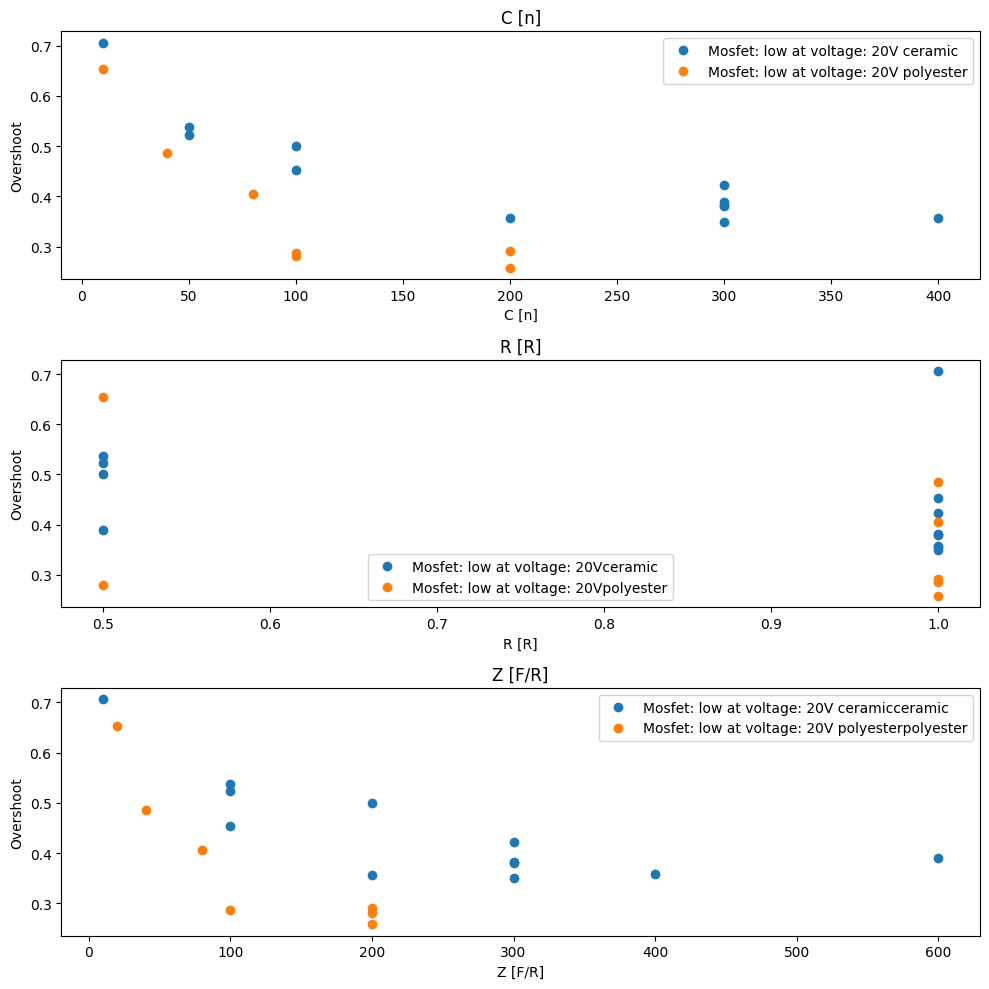

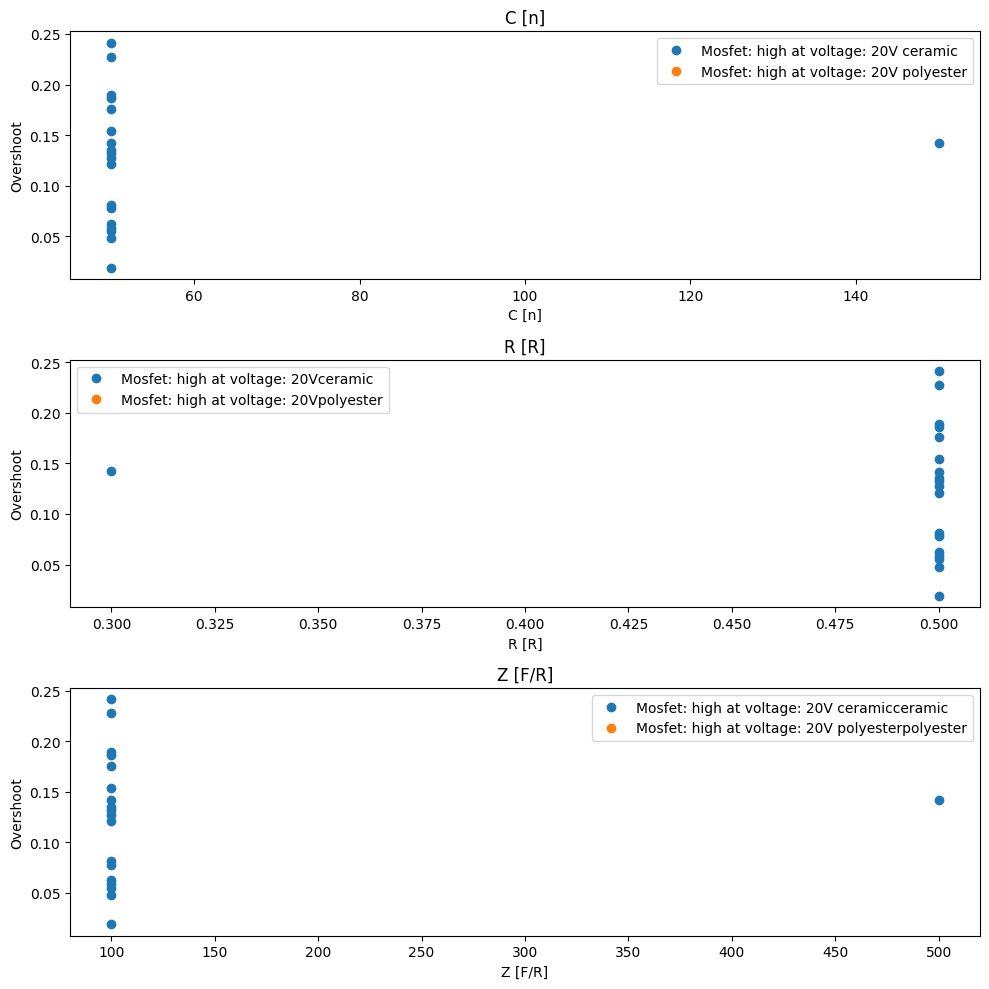

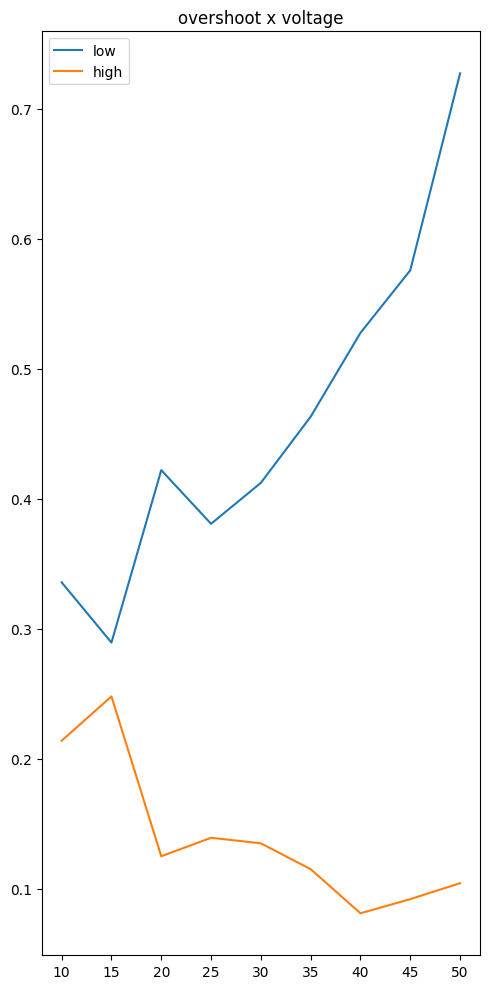

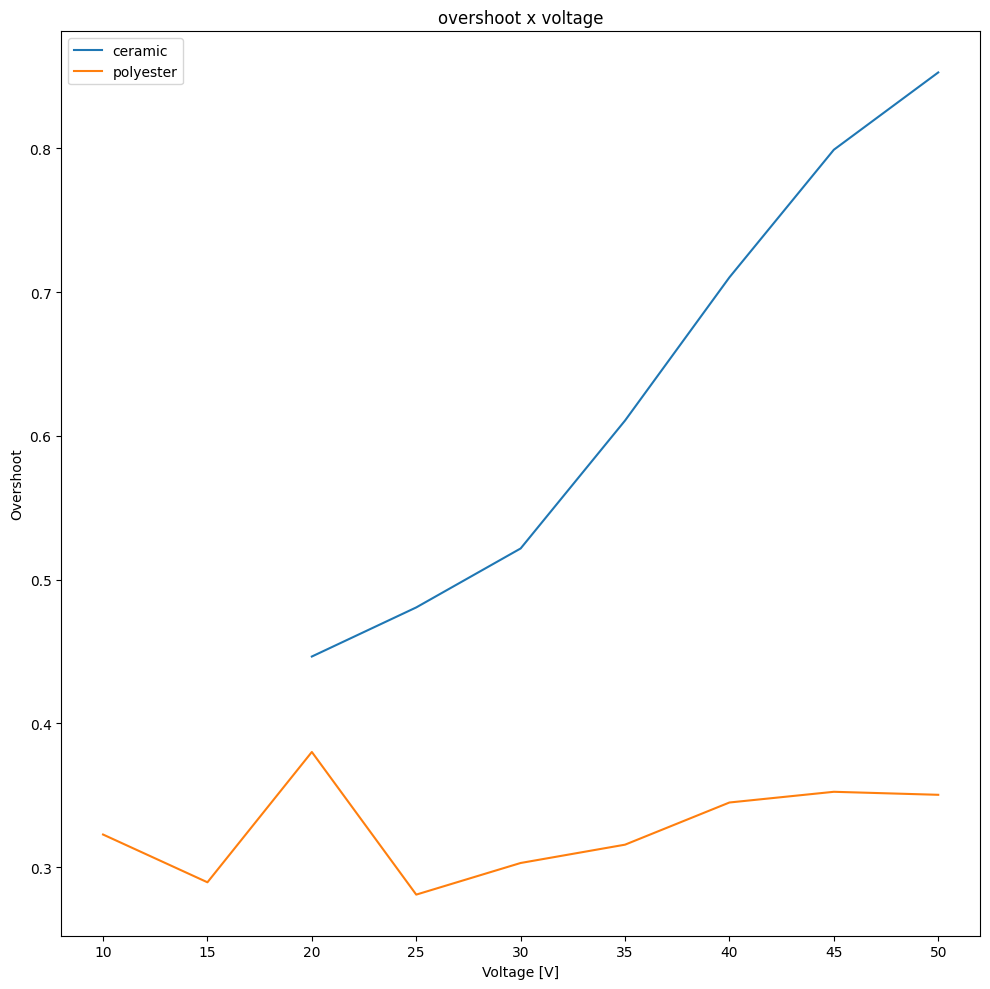

In [42]:

fig, axs1 = plt.subplots(3, 1, figsize=(10, 10))
fig2, axs2 = plt.subplots(3, 1, figsize=(10, 10))
axs = [axs1, axs2]
voltages = [20]
c_tecs = ["ceramic", "polyester"]
for i, mosfet in enumerate(dfs):
    for voltage in voltages:
        for c_tec in c_tecs:
            print("-", c_tec)
            axs[i][0].plot(dfs[mosfet][voltage][dfs[mosfet][voltage]["C_tec"] == c_tec]["C (n)"], dfs[mosfet][voltage][dfs[mosfet][voltage]["C_tec"] == c_tec]
                    ["Overshoot"],"o", label="Mosfet: " + str(mosfet) + " at voltage: " + str(voltage) + "V " + c_tec)
            axs[i][0].set_title("C [n]")
            axs[i][0].set_xlabel("C [n]")
            axs[i][0].set_ylabel("Overshoot")
            axs[i][1].plot(dfs[mosfet][voltage][dfs[mosfet][voltage]["C_tec"] == c_tec]["R (R)"], dfs[mosfet][voltage][dfs[mosfet][voltage]["C_tec"] == c_tec]
                        ["Overshoot"],"o", label="Mosfet: " + str(mosfet) + " at voltage: " + str(voltage) + "V" + c_tec)
            axs[i][1].set_title("R [R]")
            axs[i][1].set_xlabel("R [R]")
            axs[i][1].set_ylabel("Overshoot")
            axs[i][2].plot(dfs[mosfet][voltage][dfs[mosfet][voltage]["C_tec"] == c_tec]["Z (F/R)"], dfs[mosfet][voltage][dfs[mosfet][voltage]["C_tec"] == c_tec]
                        ["Overshoot"],"o", label="Mosfet: " + str(mosfet) + " at voltage: " + str(voltage) + "V " + str(c_tec) + c_tec)
            axs[i][2].set_title("Z [F/R]")
            axs[i][2].set_xlabel("Z [F/R]")
            axs[i][2].set_ylabel("Overshoot")

for ax in axs:
    for a in ax.flat:
        a.legend()
print("Ceramic cap:")
fig.tight_layout()
fig.show()
fig2.tight_layout()
fig2.show()




fig, axs = plt.subplots(1, 1, figsize=(5, 10))
for mosfet in dfs:
    voltages = list(dfs[mosfet].keys())
    voltages.sort()
    overshoots = []
    for voltage in voltages:
        overshoots.append(dfs[mosfet][voltage]["Overshoot"].mean())

    axs.plot(voltages, overshoots, label=mosfet)
    axs.legend()
    axs.set_title("overshoot x voltage")
fig.tight_layout()
fig.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
tecnologies = ["ceramic", "polyester"]
mosfet = "low"
for tecnology in tecnologies:
    voltages = list(dfs[mosfet].keys())
    voltages.sort()
    overshoots = []
    for voltage in voltages:
        overshoots.append(dfs[mosfet][voltage]
                          [dfs[mosfet][voltage]["C_tec"] == tecnology]["Overshoot"].mean())

    axs.plot(voltages, overshoots, label=tecnology)
axs.set_xlabel("Voltage [V]")
axs.set_ylabel("Overshoot")
axs.legend()
axs.set_title("overshoot x voltage")
fig.tight_layout()
fig.show()


